#Debbie's Cube

This paper presents the results of an analysis of a hyper-spectral image, using the target implant algorithm. The study compares the values of the implanted target with the original data at multiple pixel locations and analyzes the impact on the data spectrum. The paper also includes generated histograms and ROC curves for the analysis, along with A values calculated for different thresholds. The aim of the document is to provide a detailed understanding of the target implant algorithm and its impact on the data spectrum, which can be useful for various applications such as target detection in remote sensing and image processing.

In [3]:

! pip install spectral
! pip install imageio
! pip install pandas
! pip install matplotlib

!pip install scipy

  Using cached spectral-0.23.1-py3-none-any.whl (212 kB)
     ---------------------------------------- 0.0/312.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/312.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/312.7 kB ? eta -:--:--
     ---- -------------------------------- 41.0/312.7 kB 326.8 kB/s eta 0:00:01
     --------- --------------------------- 81.9/312.7 kB 512.0 kB/s eta 0:00:01
     -------------------- --------------- 174.1/312.7 kB 876.1 kB/s eta 0:00:01
     --------------------------------- ---- 276.5/312.7 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 312.7/312.7 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.7 MB 1.4 MB/s eta 0:00:08
     --------------------------------------- 0.1/10.7 MB 656.4 kB/s eta 0:00:17
     ---------------------------------------- 0.1/10.7 MB 1.1 MB/s eta 0:00:10
      ------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.0.54 requires opencv-python>=4.6.0, which is not installed.
ultralytics 8.0.54 requires PyYAML>=5.3.1, which is not installed.
ultralytics 8.0.54 requires seaborn>=0.11.0, which is not installed.
ultralytics 8.0.54 requires sentry-sdk, which is not installed.
ultralytics 8.0.54 requires thop>=0.1.1, which is not installed.
ultralytics 8.0.54 requires torch>=1.7.0, which is not installed.
ultralytics 8.0.54 requires torchvision>=0.8.1, which is not installed.
ultralytics 8.0.54 requires tqdm>=4.64.0, which is not installed.
mpl-format 0.315 requires seaborn, which is not installed.


In [1]:

from matplotlib import pyplot as plt
import numpy as np

import spectral.io.envi as envi
from scipy.ndimage import generic_filter as conv

hdr_path = "bimodal.hdr"
dat_path = "bimodal.dat"
import spectral as spec

# Visualization for Hyper Spectral Data



In [2]:
def hyper_visualize(img):
    spec.imshow(img,(0,45,90),figsize = (7,7))
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

    axs[0, 0].imshow(img[:, :, 0], cmap='gray')
    axs[0, 0].set_title('Channel 1')
    axs[0, 1].imshow(img[:, :, 29], cmap='gray')
    axs[0, 1].set_title('Channel 30')
    axs[1, 0].imshow(img[:, :, 59], cmap='gray')
    axs[1, 0].set_title('Channel 60')
    axs[1, 1].imshow(img[:, :, 89], cmap='gray')
    axs[1, 1].set_title('Channel 90')

    #plt.tight_layout()
    plt.show()

# Load The Cube



In [3]:


def load_cube(hdr_path, spectral_file):
    """
    Load a hyperspectral cube from a header file and a spectral file.
    Parameters
    ----------
    hdr_path : str
        Path to the header file.

    spectral_file : str
        Path to the spectral file.
    Returns
    -------
    cube : ndarray
        The hyperspectral cube.
    """
    header_file = str(hdr_path)
    spectral_file = str(spectral_file)

    numpy_ndarr = envi.open(header_file, spectral_file)

    cube = numpy_ndarr.read_bands(range(91)).astype('float64')  # select the bands
    CHANNELS = cube.shape[2]
    # Here, cube is an numpy nd-array

    return cube



In [4]:
cube = load_cube(hdr_path, dat_path)
print(cube.shape)    # returns (100, 100, 3)


(50, 50, 91)


a $50\times50\times91$  hyperspectral cube means that we have a total of 91 channels of hight and width of 50 pixels

C:\Users\Nain0414\.conda\envs\Unsupervised_Musical_Notes_Seperation\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


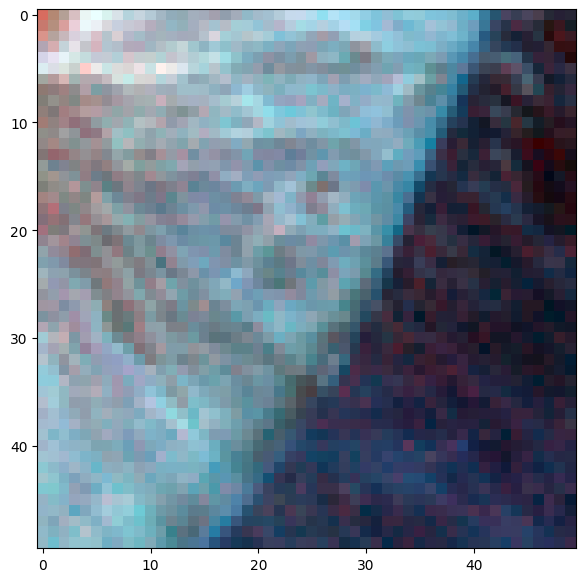

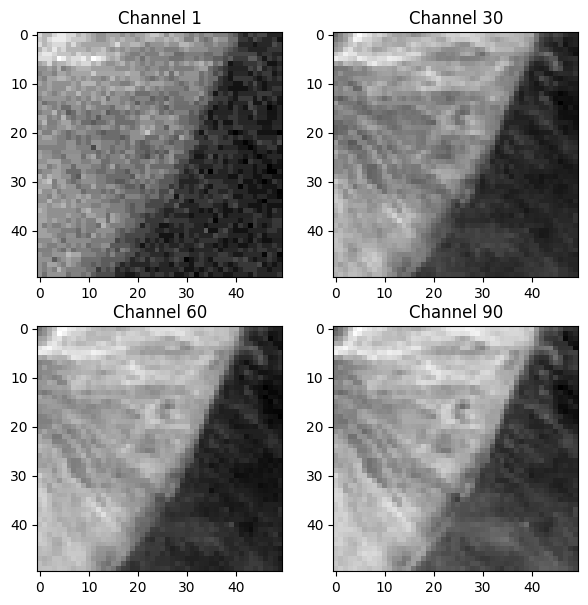

In [5]:
hyper_visualize(cube)

## Define our target, density, and treshold

In [12]:
#target's spectrum
t = cube[4,2,:]
#target's density
p= 0.01
#detection treshold
th = 0.1

## visalize our target

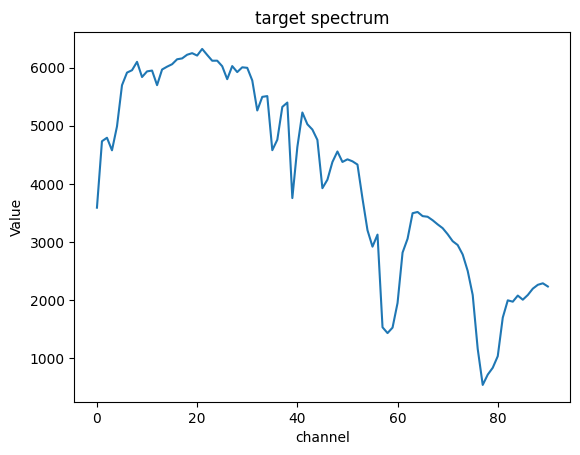

In [7]:
plt.plot(range(len(t)),t)

# Add labels and title
plt.xlabel('channel')
plt.ylabel('Value')
plt.title('target spectrum')

# Show the plot
plt.show()

# Calculate Cube's Statistics

## mean - $m$
Let's compute the statistic properties of a given 2D-pixel and its neighbors. We will first calculate the estimator, denoted as $m$, which is an estimation of the cube $x$. The estimator for every pixel is simply the mean of its immediate neighbors. Instead of calculating this directly using loops and addressing edge cases, we can compute this quite easily using convolution.

Let $X$ be a $3\times 3$ matrix of the given 2D-pixel and its neighbors. We can calculate the estimator $m$ as follows:

$m = \frac{1}{8}\sum\limits_{\substack{i=1 \ j=1}}^{3} X_{i,j} - \frac{1}{8} X_{2,2}$




​
 

Here, we convolve $X$ with a $3\times 3$ matrix $k= \frac{1}{8} \times \begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1
\end{bmatrix}$

 to obtain what we need. This is beneficial since we no longer have to take into account edge pixels, which have five neighbors, and corner pixels, which have only three neighbors. The only consideration for edges is dividing by the correct number of neighbors. We can accomplish this by using the function build_norm_mat that builds a normalizing matrix of the desired size.

In [8]:

def compute_m(cube):
    M = np.zeros(cube.shape)

    # Define kernel for convolution                                         
    kernel = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]]) 
    for c in range(M.shape[-1]):

        # Perform 2D convolution with input data and kernel 
        
        #M[:,:,c] = signal.convolve2d(cube[:,:,c], kernel, boundary='wrap', mode='same')/8
        M[:,:,c] = conv(cube[:,:,c],
                        np.nanmean,
                        size=3,
                        footprint=kernel,
                        mode='constant',
                        cval=np.NaN)
    return M

M = compute_m(cube)
print (M.shape)


C:\Users\Nain0414\AppData\Local\Temp\ipykernel_14816\190340579.py:13: UserWarning: ignoring size because footprint is set
  M[:,:,c] = conv(cube[:,:,c],


(50, 50, 91)


### visualize $m(i,j)$

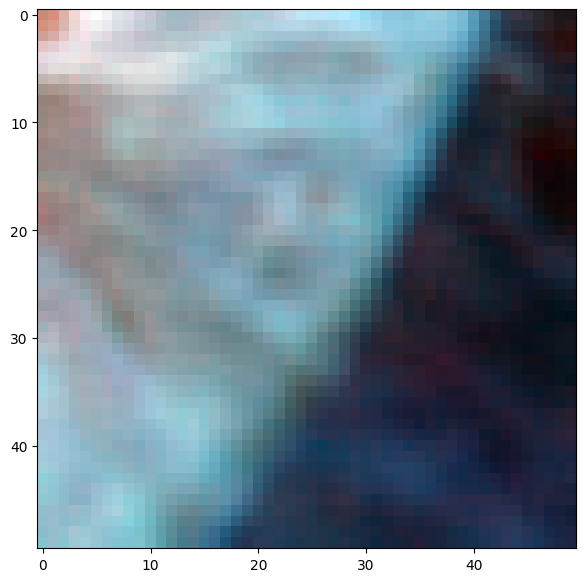

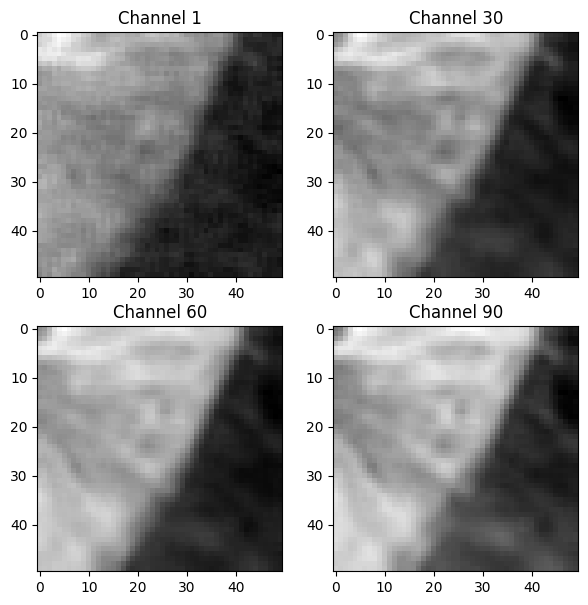

In [9]:
hyper_visualize(M)

# the mean difference estimator

Here, we are computing an estimator of the difference between a pixel's value and the mean value of its neighbors. This is a common technique in image processing known as local mean subtraction. The idea behind this is that if a pixel's value deviates significantly from the mean value of its neighboring pixels, then it may be part of a target object.

More formally, let X be the value of a pixel at location $(i,j)$ in an image, $M(i,j)$ is the mean value of the neighboring pixels of X. Then, the estimator of the difference between X and M(i,j) is given by:

$E[X-M(i,j)] = X(i,j) - M(i,j)$

where X and M(i,j) are both scalar values representing the intensity of the pixel at location (i,j) and the mean intensity of its neighboring pixels, respectively.

Once we have computed the estimator for each pixel in the image, practically we can use a thresholding technique to classify pixels as target or non-target. Pixels with a large positive value of E(X-M(i,j)) are more likely to be part of a target object, while pixels with a small or negative value are more likely to be part of the background.

however we will use the more sophisticated method, involving a mached filter, more on that in the next blocks.



In [10]:
diff_estimator = cube - M
diff_estimator_wt = diff_estimator +p*t

In [11]:
from tabulate import tabulate

# Define the table data as a list of lists
table = [
    ["Pixel location", "NT", "WT"],
    ["(5,5)", diff_estimator[4,4,0],  diff_estimator_wt[4,4,0]],
    ["(10,10)", diff_estimator[9,9,0],  diff_estimator_wt[9,9,0]],
    ["(15,15)",diff_estimator[14,14,0],  diff_estimator_wt[14,14,0]],
    ["(20,20)", diff_estimator[19,19,0],  diff_estimator_wt[19,19,0]]
]

print("\tvalues of (x'-m):\n")
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


ModuleNotFoundError: No module named 'tabulate'

#  Covariance Matrix - $\phi$
## Computing the Matrix
The covariance matrix we need is actually the auto-covariance matrix of the cube given by $\phi = E[ (X-m)·(X-m)^T]$

even though auto-covariance matrices are typically obtained from random vectors, not 3D matrices. However, in numpy, a random variable can be represented as a vector of samples from its distribution, which allows us to discuss statistical properties like mean and variance. Thus, a random vector can be a matrix where each row represents a single random variable. In our case, each of the 91 images in the cube is a random variable that has been sampled and organized into a matrix. 

so, if we concatenate the rows of each channel $c$ to form a $ 2500\times1 $ vector, we can represent the cube as a random vector of length 91. 

This new vector has the same statistical properties as the original images, and its auto-covariance matrix, sized 91x2500, is what we are looking for.



##

In [13]:
# Reshape X_MINUS_M to a 2D array of size (x_size*y_size) by num_of_bands
X,Y, n_bands = cube.shape

X_MINUS_M = np.reshape(diff_estimator, (X*Y, n_bands))
CUBE      = np.reshape(cube,           (X*Y, n_bands))
# Compute the covariance matrix of the reshaped array
phi = np.cov(X_MINUS_M, rowvar=False)


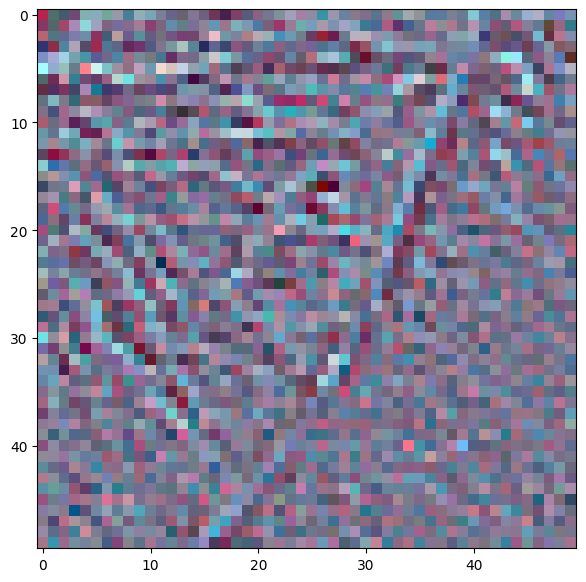

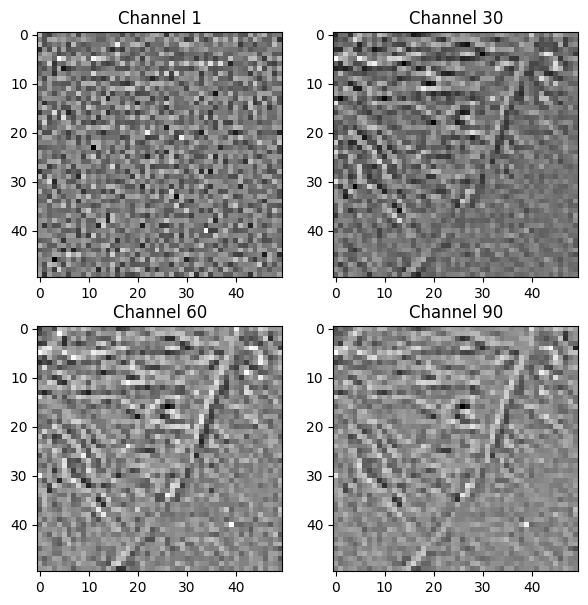

-56.75


In [14]:
hyper_visualize(diff_estimator)
print(diff_estimator[4,4,0])

# Matched Filter

We are now ready to proceed with running the MF algorithm as intended. We will be running the algorithm twice per 90-entry-pixel $X(i,j)$ $i,j \in [0,50]$.

 First, we will run the algorithm with no target (NT). Secondly, we will be planting a certain percentage of the target (in our case $p = 0.01 $) in each pixel (WT).

the mached filter is of the form:
 $t^T \phi^{-1}(x'-m)$

when $\phi , m$ were already calculated, and $x'$ will represent a pixel: once implanted with a target (WT), and once as is (NT)

In [15]:
Matched_Filter_NT = np.zeros((X,Y))
Matched_Filter_WT = np.zeros((X,Y))

MF_coef = t.T @ np.linalg.inv(phi)
MF_coef.shape

(91,)

In [16]:

print(X_MINUS_M.shape)

for i in range(X):
    for j in range(Y):

        Matched_Filter_NT[i,j] = MF_coef @ diff_estimator[i,j,:]
        Matched_Filter_WT[i,j] = MF_coef @ diff_estimator_wt[i,j,:]



(2500, 91)


In [17]:
Matched_Filter_WT.shape


(50, 50)

In [18]:
table = [
    ["Pixel location", "NT", "WT"],
    ["(5,5)", Matched_Filter_NT[4,4],  Matched_Filter_WT[4,4]],
    ["(10,10)", Matched_Filter_NT[9,9],  Matched_Filter_WT[9,9]],
    ["(15,15)",Matched_Filter_NT[14,14],  Matched_Filter_WT[14,14]],
    ["(20,20)", Matched_Filter_NT[19,19],  Matched_Filter_WT[19,19]]
]

print("  values of the matched filter's output:\n")
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


  values of the matched filter's output:



NameError: name 'tabulate' is not defined

# Results

now for the important part: let's see if we managed to get a good detector!

## Histogram

the histogram will reveal the distribution of the matched filter's output, for innocent pixels, and for target implanted ones.
this will give us a good insight as to weathere there exists a treshold value such that we can decide confidently that a pixel contains a target for outputs above it.

In [19]:
Matched_Filter_NT = Matched_Filter_NT.reshape(X*Y)
Matched_Filter_WT = Matched_Filter_WT.reshape(X*Y)

In [20]:


def plot_histograms(Matched_Filter_WT,Matched_Filter_NT, start = -1000, end = 1500, bins = 101):

    axs = np.linspace(start, end, bins)
    NT_val, NT_bins = np.histogram(Matched_Filter_NT, axs)
    WT_val, WT_bins = np.histogram(Matched_Filter_WT, axs)

    fig, ax = plt.subplots()
    ax.plot(axs[:-1], NT_val, label='No target')
    ax.plot(axs[:-1], WT_val, label='With target')
    ax.set(title='Original Histogram', xlabel='Bins', ylabel='Frequency')
    ax.legend()
    fig.set_size_inches(5, 5)
    plt.show()

In [21]:
from scipy.integrate import cumtrapz


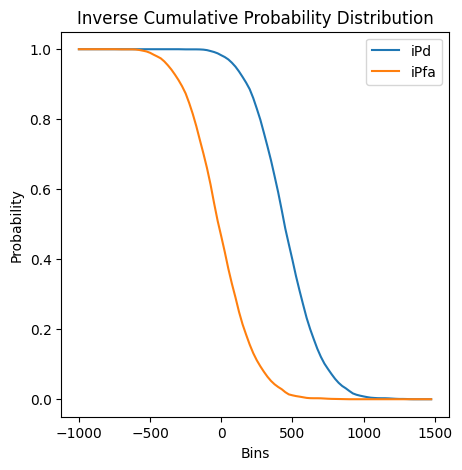

In [127]:
def plot_ipd(Matched_Filter_WT,Matched_Filter_NT,start = -1000, end = 1500, bins = 101):
    axs = np.linspace(start, end, bins)
    NT_val, NT_bins = np.histogram(Matched_Filter_NT, axs)
    WT_val, WT_bins = np.histogram(Matched_Filter_WT, axs)

    x_size = len(Matched_Filter_WT)
    y_size = len(Matched_Filter_NT)

    dx = (end-start)/(bins - 1)

    ipd = 1 - cumtrapz(WT_val,axs[:-1], initial=0)/(dx*X*Y)
    ipfa = 1 - cumtrapz(NT_val,axs[:-1], initial=0)/(dx*X*Y)

    fig, ax = plt.subplots()
    ax.plot(WT_bins[:-1], ipd, label='iPd')
    ax.plot(NT_bins[:-1], ipfa, label='iPfa')
    ax.set(title='Inverse Cumulative Probability Distribution', xlabel='Bins', ylabel='Probability')
    ax.legend()
    fig.set_size_inches(5, 5)
    plt.show()

    return ipd,ipfa

ipd, ipfa = plot_ipd(Matched_Filter_WT,Matched_Filter_NT)

# Roc Curve

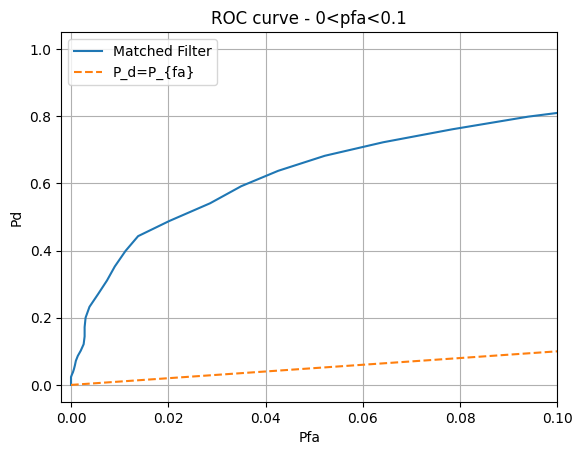

In [23]:
def plot_ROC(ipd,ipfa):
    plt.figure()
    plt.plot(ipfa, ipd)
    plt.plot(np.linspace(0,0.1), np.linspace(0,th), '--')
    plt.title('ROC curve - 0<pfa<0.1')
    plt.grid()
    plt.xlabel('Pfa')
    plt.ylabel('Pd')
    plt.legend(['Matched Filter', 'P_d=P_{fa}'], loc='upper left')
    plt.xlim([-0.002, th])
    plt.show()

plot_ROC(ipd, ipfa)

</br>

<font size="15">**Part 2: Truth Will Set you free**</font>
 here, in part  2, we will be creating the mached filter using the true X value, instead of the estimated one, previously denoted by $m$. we will use the fact that the underline image is known to us in order to examine the effect of accuratly estimating the pixel value on the detection performance.

matched filter we were using so far was of the form

$$t^T \phi^{-1}(x'-m)$$

a better method is to apply a normalized filter of the form:

$$\frac{(t-m)^T \phi^{-1}(x'-m)}{\sqrt{(t-m)^T \phi^{-1}(t-x)}}$$
where $m$ is the mean value of the pixel's neighbors, and $x'$ is the pixel value with or without the target implanted in it.
notice, $m$ is used here as an **estimator** for the true value of the pixel, $x$.
meaning, we only use it because we don't know the true value of the pixel underneath the target that might be covering it, we have to estimate it.

In this part, we will be using the true value of the pixel, $x$, instead of the estimated one, $m$ to demonstrate the maximal benefit of accurately estimating the background.

we will apply:
$$\frac{(t-x)^T \phi^{-1}(x'-m)}{\sqrt{(t-x)^T \phi^{-1}(t-x)}}$$
where $x$ is the true value of the pixel, and $x'$ is the pixel value with or without the target implanted in it.

In [131]:
def truth_mached_filter(cube, t):

    X,Y, n_bands = cube.shape

    Matched_Filter_NT = np.zeros((X,Y))
    Matched_Filter_WT = np.zeros((X,Y))

    M = compute_m(cube)

    diff_estimator = cube - M
    diff_estimator_wt = diff_estimator +0.1*t

    X_MINUS_M = np.reshape(diff_estimator, (X*Y, n_bands))
    CUBE      = np.reshape(cube,           (X*Y, n_bands))

    # Compute the covariance matrix of the reshaped array
    phi = np.cov(X_MINUS_M, rowvar=False)

    # Compute the matched filter
    mf_coef =  (t - cube) @ np.linalg.inv(phi)

    for i in range(X):
        for j in range(Y):
            denominator= np.sqrt(mf_coef[i,j] @ (t - cube[i,j,:]))

            Matched_Filter_NT[i,j] = mf_coef[i,j] @ diff_estimator[i,j,:]/ denominator
            Matched_Filter_WT[i,j] = mf_coef[i,j] @ diff_estimator_wt[i,j,:] /denominator

    print(mf_coef.shape)

    return Matched_Filter_WT, Matched_Filter_NT

t = np.mean(np.array([cube[5,5,:],cube[5,4,:],cube[5,6,:],cube[6,5,:]]), axis=0)
print(t.shape)
truth_matched_filter_WT, truth_matched_filter_NT = truth_mached_filter(cube, t)


(91,)


C:\Users\Nain0414\AppData\Local\Temp\ipykernel_14816\190340579.py:13: UserWarning: ignoring size because footprint is set
  M[:,:,c] = conv(cube[:,:,c],


(50, 50, 91)


# Examine the results

let us plot the histograms of matched filter scores, the respective ICPD and ROC curve to better understand the detection ratio:

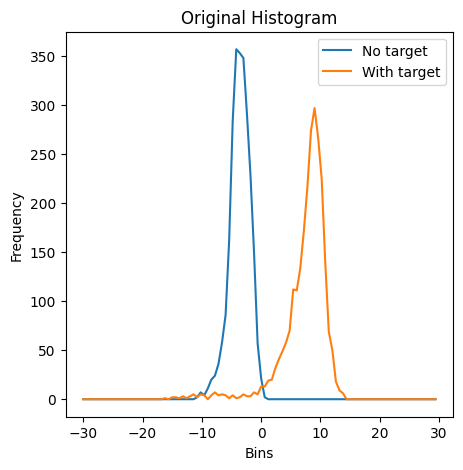

[656.49494715 427.30299065 110.91621677 ... 640.82207159 669.2378701
 413.16782055]


In [136]:


plot_histograms(truth_matched_filter_WT,truth_matched_filter_NT,start=-30, end=30)
print(Matched_Filter_WT)

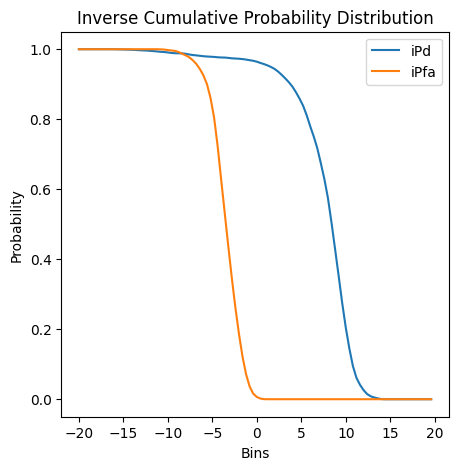

In [137]:
ipd, ipfa = plot_ipd(truth_matched_filter_WT,truth_matched_filter_NT,start=-20, end=20)


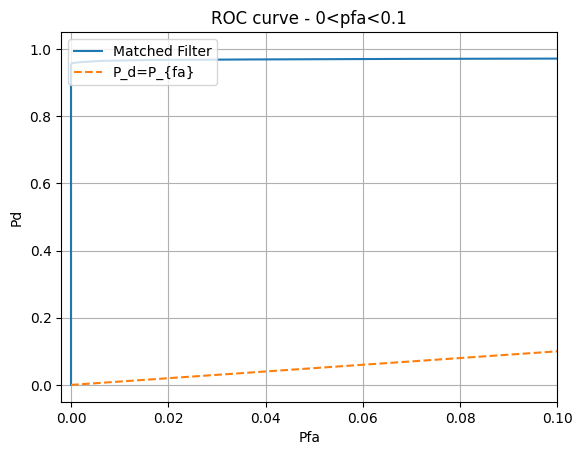

In [138]:
plot_ROC(ipd,ipfa)

it worked!! detection is close to perfect, and it makes sense: the matched filter KNOWS for a fact what is the value of the noise; which is the background, $X$ in our case. it also knows the spectral properties of the target signal. so, in theory, detection, or SNR, shuld be ideal.

# Innovation: harvesting the power of Machine Learning to estimate background!

in the last section, we saw just how powerful it can be to estimate the background accurately. in the following one, we shall go on an unknown jurny in which we will attempt to make that exact estimation, using powerful machine learning algorithms.

## let's plot the data

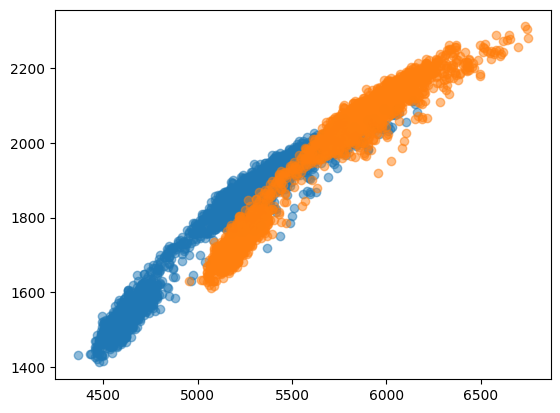

In [79]:
cube_wt = cube + p*t
#colors = np.random.rand(N)
plt.scatter(cube[:,:,15], cube[:,:, 75], alpha=0.5)
plt.scatter(cube_wt[:,:,15], cube_wt[:,:, 75], alpha=0.5)
plt.show()

## GMM implementation


The Gaussian Mixture Model is a statistical model that assumes that the observations follow a normal distribution, ie $f(x|z)$ is a Gaussian distribution with expectation $µ_Z$ and covariance matrix $Σ_Z$. The random variable $Z$
is a hidden variable.


to differentiate those clusters, it seems that we could use the help of a machine learning clustering based background estimation algorithm!

## MLE Overview

this time we will use the MLE algorithm to cluster the data.

pseudo code: The MLE algorithm goes as follows

here is MLE algorithm in pseudo code

1.until convergence, repeat:

   #### E-step:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

#### M-step:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$


this is what the implementation looks like in python:



In [130]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0

    for i in range(n):
        norm_i = 0
        for j in range(k):
            # m = mu[j]
            # sig = sigma[j]
            # x = data[i]
            # pdf_value = 1 / (np.sqrt((2 * np.pi)**90 * np.linalg.det(sig))) * np.exp(
            #     -0.5 * np.dot(np.dot((x - m), np.linalg.inv(sig)), (x - m).T)
            # )
            # w[j, i] = pdf_value * phi[j]
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            #print(sigma)
            #print(f'w[{j},{i}]:{w[j, i]}') # here is the problem 🪲🐜🐛🐜🪲
            norm_i += w[j, i]
        w[:, i] /= norm_i

        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w, dtype = np.float64)
    #print(f'********************\n sum of  all w: {sum_of_all_w}')
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j],dtype=np.float64)
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def MLE(data, initial_model, case = 2,iter =20):


    # 1. Initialize model parameters

    phi, mu, sigma = initial_model

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]



    while not converged and i<iter:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        if case == 1:
            _, mu, _ = M_step(data, w, phi, mu, sigma)
        if case == 2:
            phi, mu, sigma = M_step(data, w, phi, mu, sigma)

        # Plot:
        if i%20 == 0 or i < 5:
            c=1+w[0]-w[1]

            plt.scatter(data[:,0], data[:, -1], c=1+w[0]-w[1], alpha=0.1,cmap='RdYlBu')
            plt.title("iteration #" + str(i))
            plt.show()
            #print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.0001)
    # 5. return model
    return phi, mu, sigma, iteration_log_likelihood,w



### Initial Model:

to run the MLE algorithm, first, we will need an initial model to start with.  algorithm demands initial value  $\theta_0$ ie. initial values
for:  $\mu_j , \sigma^2_j , \phi_j$

(spoiler: one idea would be to use K-means algorithm to initialize the means of the model. we will experiment with that later), but first we will try initiating with an arbitrary choice, as such:

In [30]:
def initial_model(c,d,*args):
    """

    :param c: # of Gaussians in model
    :param d: # of dimentions of datapoints

    :return: an arbitrary initial condition  model for MLE. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """


    mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])

    if len(args) == 0:
        phi = np.random.rand(k)
        phi /= sum(phi)


        sigmas = np.zeros((k,d,d))

        for i in range(k):
            sigma = np.random.rand(d, d)
            sigma = np.dot(sigma, sigma.T)
            sigmas[i] = sigma
        print("initiating a random model...")

    else:
        phi, sigma = args
        print("initiating a model with given phi,sigma...")
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

## convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$


and compare to previous value, to check for convergence.

# Let's try it out:

In [66]:
cube_wt = cube + p*t

In [128]:
k = 2
d = 91
X,Y =25,25
# Reshape to (2500, 90) each
cube_data = np.reshape(cube[:25,:25], (625, d))/10000
cube_wt_data = np.reshape(cube_wt[:25,:25], (625, d))/10000

# Combine A and B arrays vertically
data = np.vstack((cube_data, cube_wt_data)).astype(np.float64)

print(data)

[[0.3552    0.4538    0.4553    ... 0.1868    0.189     0.1839   ]
 [0.3461    0.4538    0.4577    ... 0.1927    0.1957    0.1893   ]
 [0.3461    0.4538    0.4649    ... 0.2008    0.2031    0.1983   ]
 ...
 [0.3579775 0.4717675 0.478555  ... 0.2204725 0.2227025 0.2175925]
 [0.3625775 0.4685675 0.473755  ... 0.2206725 0.2232025 0.2178925]
 [0.3579775 0.4717675 0.476155  ... 0.2232725 0.2263025 0.2211925]]


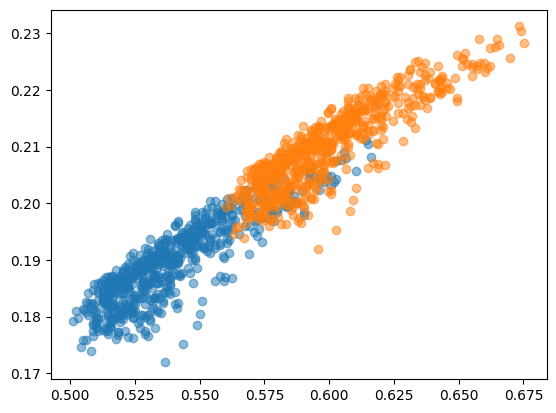

In [129]:
plt.scatter(cube_data[:,15], cube_data[:, 75], alpha=0.5)
plt.scatter(cube_wt_data[:,15], cube_wt_data[:, 75], alpha=0.5)
plt.show()

In [106]:


phi, mu, sigma, lol,w = MLE(  data,
                            initial_model(k,91))

initiating a random model...
phi:  [0.78995246 0.21004754] 

mu:  [[ 1.53128892e+00 -2.14908248e+00 -7.31986715e-02 -3.36936343e-01
   4.91331239e-01 -8.00311091e-01  1.47028026e-01  5.64808568e-02
  -1.82959958e+00 -2.91454144e-01  8.34806566e-01 -7.71023322e-01
   7.56984658e-01 -1.24349340e+00  3.34430523e-01 -2.58639037e-01
   9.92907561e-02  3.20713241e-01 -1.92057152e-01  3.25425317e+00
   2.72410125e-01  1.29389629e+00 -8.15142398e-02 -6.18975739e-02
   1.45394692e+00 -4.31198718e-01 -1.74935866e+00  1.46365040e-01
  -1.26595001e+00 -4.22638695e-01  2.28502382e-02  1.34020725e+00
   8.54212346e-01  5.30542041e-01  8.45376995e-01 -3.37623946e+00
  -1.81048282e-01  1.52867700e+00 -1.03109801e+00 -5.62157066e-01
  -1.64875209e-01  1.48217947e+00 -6.29050084e-01 -4.33922783e-01
  -6.66177638e-01  4.54559789e-01 -1.28195861e+00  1.72162798e+00
   1.28380924e+00 -2.58093596e-03  1.13539260e+00 -6.98043992e-01
   1.23910506e+00  2.35470559e+00 -9.57214720e-01  3.99021672e-02
   6.90467

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

## Oh no, it didn't quite go as expected

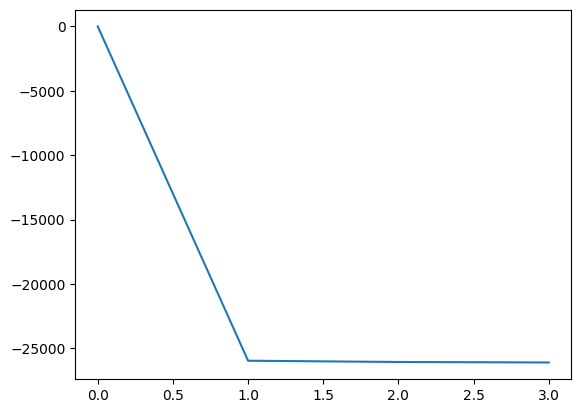

In [107]:
plt.plot(lol)

## Two Solution Ideas:

- Dimension reduction
- Smarter Model Initialization

In [108]:
def K_means_cluster(k, data, dim=91):
    # 1. randomly select k data points as
    #    centroids
    centroids = [np.mean(data, axis=0), np.mean(data, axis=0)+np.std(data, axis=0)]
    # for i in range(k):
    #     mean = np.random.uniform(0.45,0.55,size=dim)
    #     centroids.append(mean)

    i=0
    dif = 1
    tol= 0.00001
    # 3. repeat until the centroids converge:
    while (i <= 50) and dif > tol: #TODO: add condition
        previous_centroids = np.array(centroids)

        # 2. calculate the distance between
        #    each data point and each centroid
        d = []
        for dp in data:
            distance = [np.linalg.norm(dp - ci) for ci in centroids]
            d.append(distance)
        d = np.array(d)


        # 4. assign each data point to the cluster with the nearest centroid
        clusters = [[], []]
        for i, dp in enumerate(d):
            closest_centroid = np.argmin(dp)
            clusters[closest_centroid].append(list(data[i]))

        fig = plt.figure()
        ax1 = fig.add_subplot()
        colors = ['r','b','g','y']
        for n in range(k):
            x = [row[0] for row in clusters[n]]
            y = [row[70] for row in clusters[n]]
            ax1.scatter( x, y , c=colors[n%4],alpha=0.3, label='first')

        ax1.scatter([row[0] for row in np.array(centroids)], [row[70] for row in np.array(centroids)], c='m',marker="x",label='centroids')


        plt.legend(loc='upper left');
        plt.show()

    # 5. recalculate the centroid of each cluster
        for i, c in enumerate(clusters):
            centroids[i] = np.mean(c,axis=0)
        dif = np.linalg.norm(centroids-np.array(previous_centroids))
        print("dif", dif)
    """
    return the initial model generated from the k means
    """
    # phi is the probability of each cluster in the data
    phi =np.array([len(clusters[t])/len(data) for t in range(k)])

    sigma = np.zeros((k,dim,dim))
    for j, c in enumerate(clusters):
        sigma[j] = np.mean([np.outer((d - centroids[j]).T, d - centroids[j]) for d in c],axis = 0)

    return phi, np.array(centroids), sigma

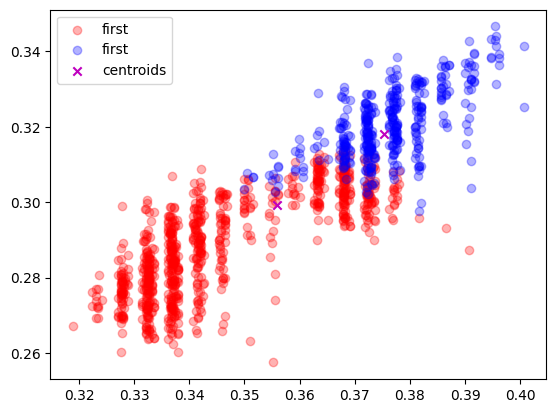

dif 0.14424126924364358


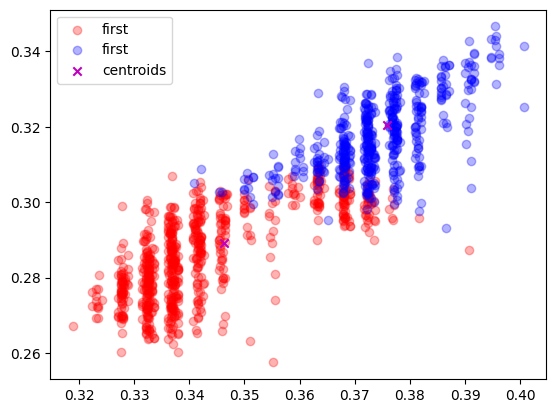

dif 0.053101641607224775


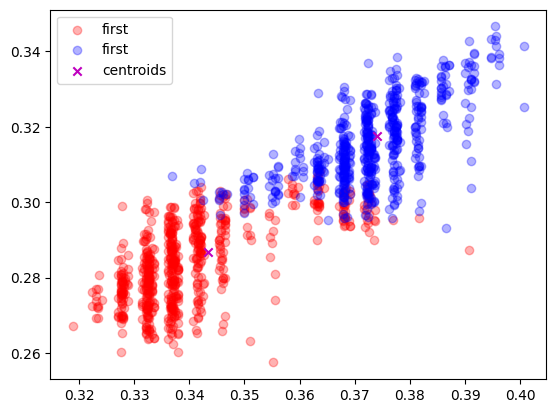

dif 0.04183567541029862


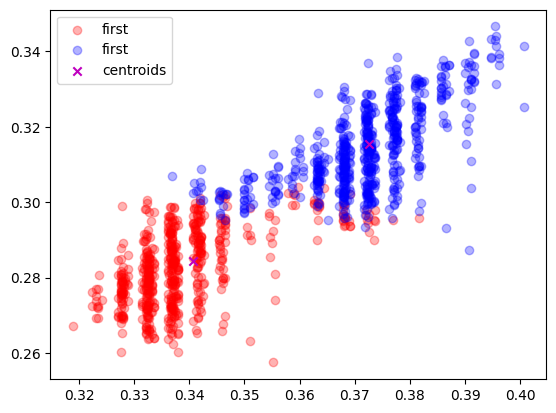

dif 0.02774897081101518


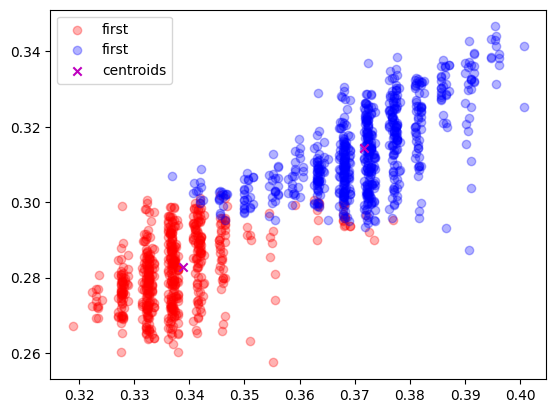

dif 0.014248330206336583


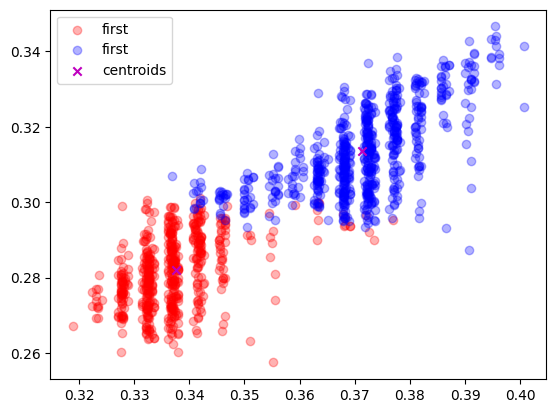

dif 0.007640654702309989


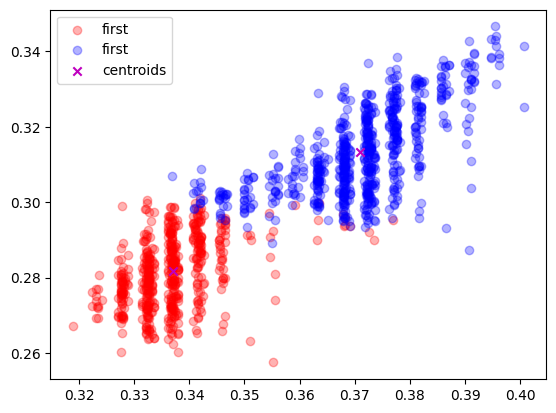

dif 0.0036057882417617287


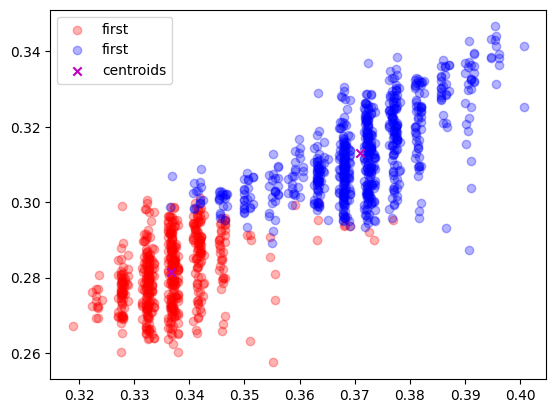

dif 0.0020555215301945357


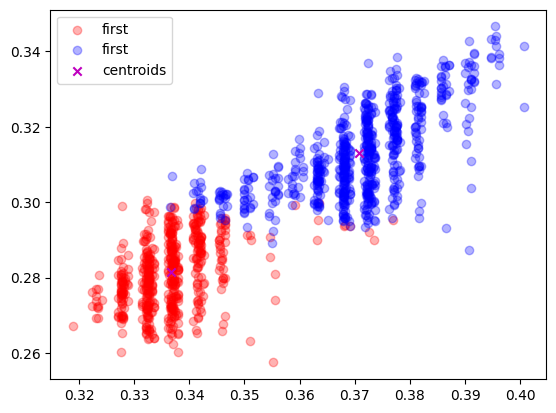

dif 0.0010290370948689543


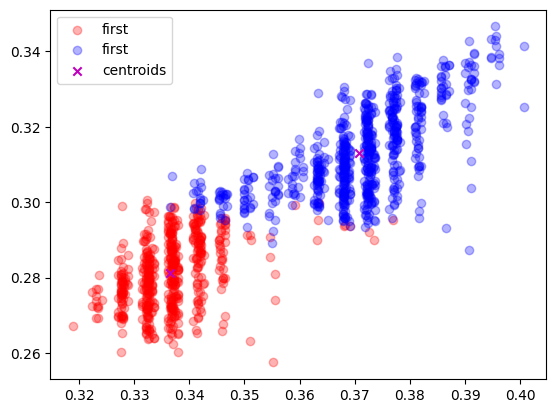

dif 0.0005260599932980496


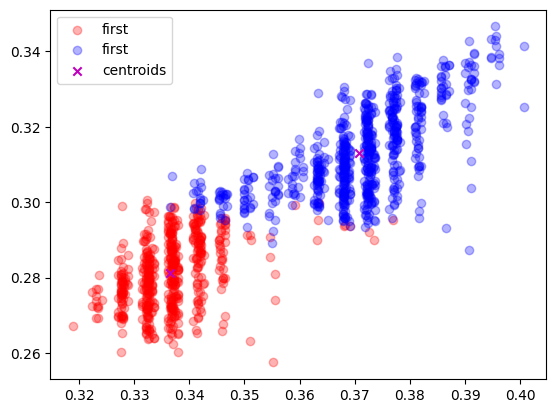

dif 0.0


In [109]:
phi, centroids, sigma =  K_means_cluster(2, data,dim=91)


## set scores according to cluster alignment

In [110]:

scores_nt = [np.linalg.norm(dp - centroids[0]) - np.linalg.norm(dp - centroids[1]) for dp in cube_data]
scores_wt = [np.linalg.norm(dp - centroids[0]) - np.linalg.norm(dp - centroids[1]) for dp in cube_wt_data]



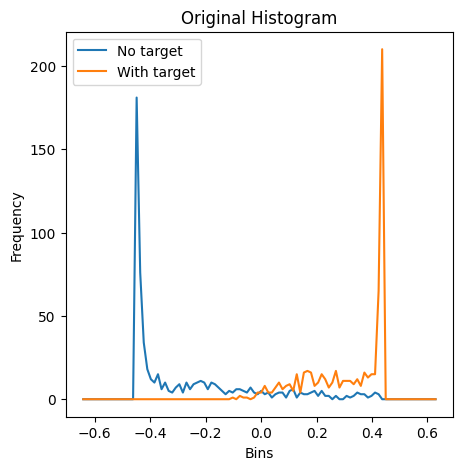

In [111]:
plot_histograms(scores_wt,scores_nt, start = min(scores_nt)-0.2, end = max(scores_wt)+0.2, bins = 101)

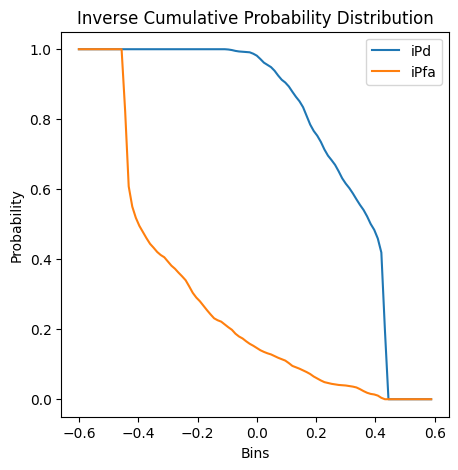

In [115]:
ipd, ipfa = plot_ipd(scores_wt,scores_nt,start = -0.6, end = 0.6,X=25,Y=25)


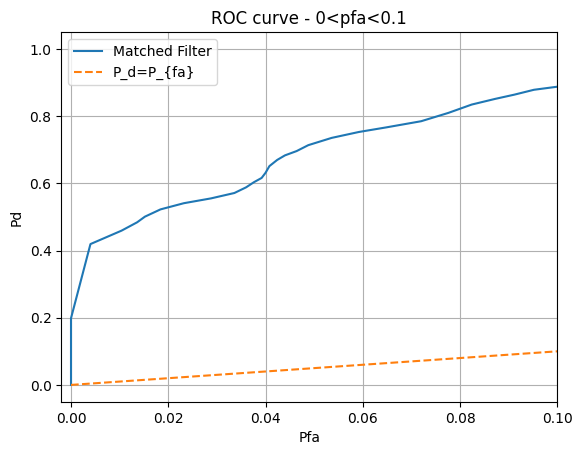

In [116]:
plot_ROC(ipd, ipfa)


In [117]:
def K_means_initial_model(k,d,data, dim = 91):
    """

    :param k: # of Gaussians in model
    :param d: # of dimentions of datapoints
    :return: an arbitrary initial condition  model for EM. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    phi, mu, sigmas = K_means_cluster(k, data,dim=dim)

    # sigmas = np.zeros((k,d,d))
    # for i in range(k):
    #     sigma = np.random.rand(d, d)
    #     sigma = np.dot(sigma, sigma.T)
    #     sigmas[i] = sigma

    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

In [118]:
print(sigma[:,[10,70],[10,70]])
print(phi)
print(mu[:,[10,70]])

[[2.01991609e-04 8.31771027e-05]
 [4.31723609e-04 1.30567833e-04]]
[0.4328 0.5672]


IndexError: index 10 is out of bounds for axis 1 with size 5

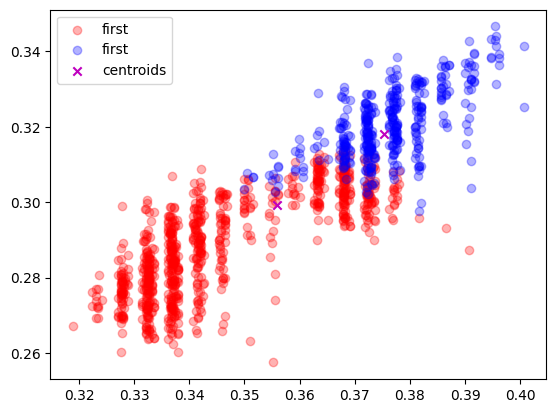

dif 0.14424126924364358


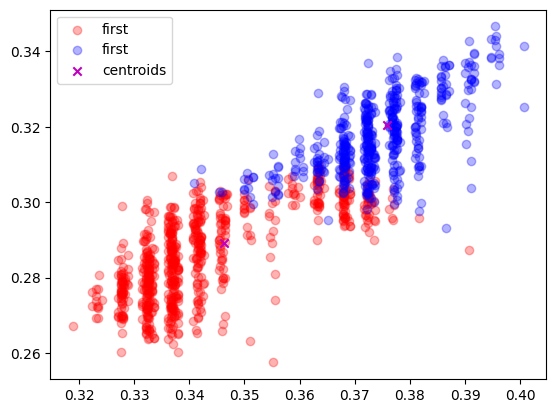

dif 0.053101641607224775


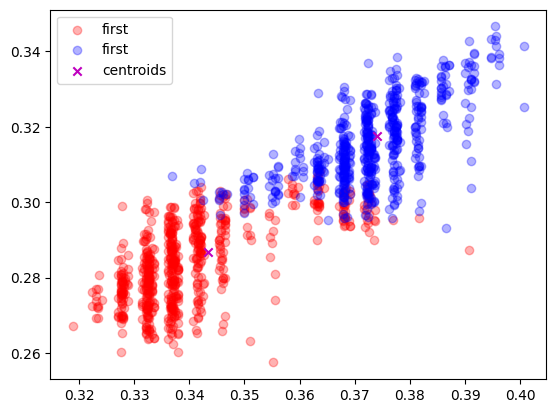

dif 0.04183567541029862


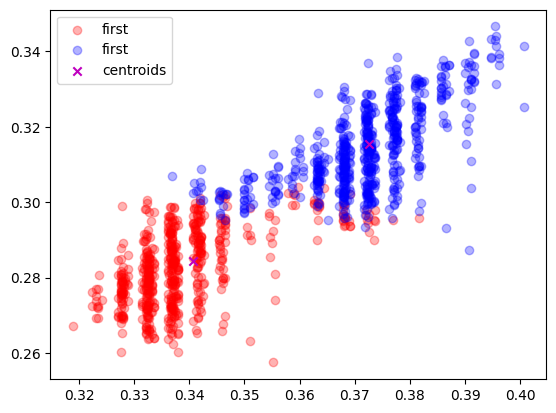

dif 0.02774897081101518


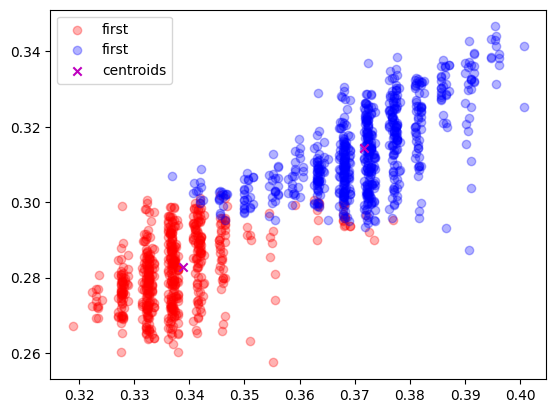

dif 0.014248330206336583


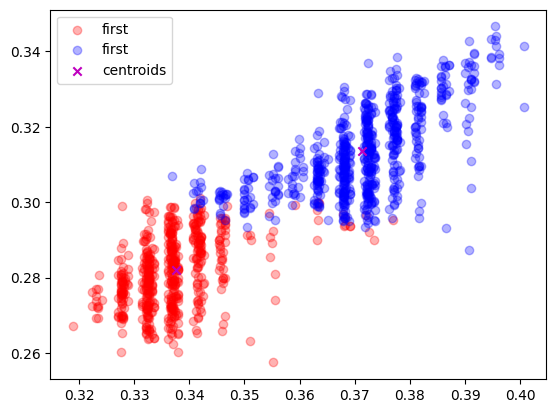

dif 0.007640654702309989


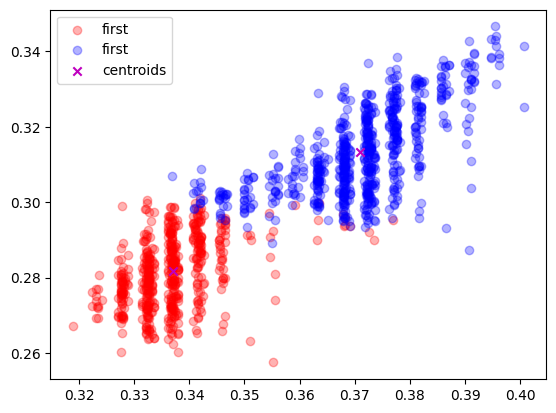

dif 0.0036057882417617287


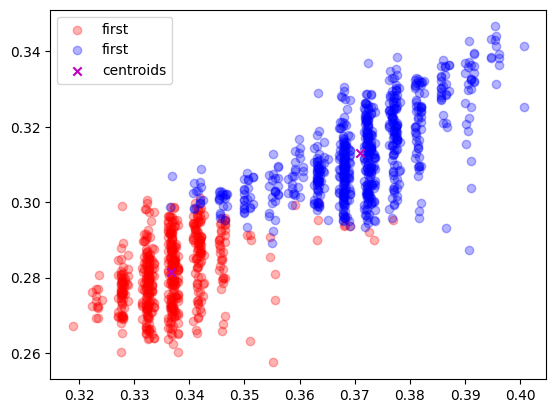

dif 0.0020555215301945357


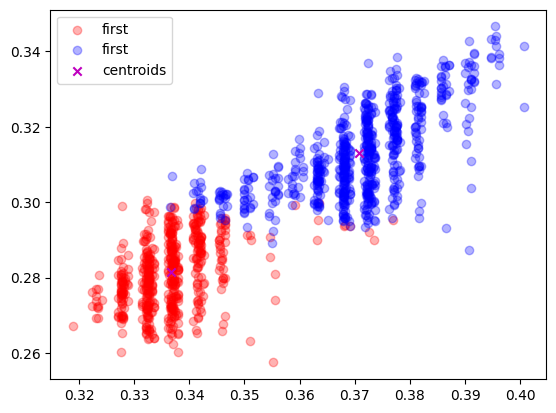

dif 0.0010290370948689543


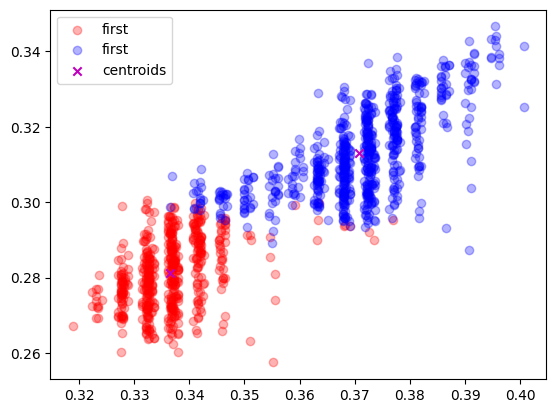

dif 0.0005260599932980496


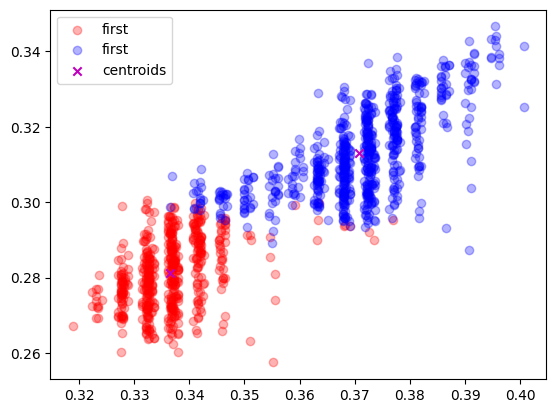

dif 0.0
phi:  [0.4328 0.5672] 

mu:  [[0.33652694 0.4399689  0.44305573 0.42037209 0.45659566 0.51836488
  0.53530023 0.53630578 0.54593433 0.52126044 0.52810365 0.52743933
  0.50448868 0.52612482 0.53192066 0.53339298 0.53843854 0.5382018
  0.54385832 0.54420065 0.54158387 0.55128614 0.54123752 0.53261419
  0.53433923 0.5248061  0.50779977 0.52743831 0.51964524 0.52076077
  0.51919732 0.4990354  0.45711146 0.47470698 0.47720656 0.39601423
  0.41275046 0.46163683 0.47100259 0.32655314 0.40461437 0.45534034
  0.43954982 0.42998031 0.41707837 0.34579598 0.35879316 0.38506368
  0.40116788 0.38659917 0.38962726 0.38796091 0.38226788 0.33045762
  0.28518623 0.25872209 0.27690518 0.13546437 0.12658845 0.13547944
  0.17402218 0.2504915  0.27251178 0.31145564 0.31358558 0.30792181
  0.30700397 0.30223494 0.29637449 0.28993868 0.28131553 0.27112639
  0.26472837 0.25078886 0.2249604  0.18782006 0.10356215 0.04840162
  0.06450906 0.07549931 0.09294418 0.15247038 0.17964556 0.17740786
  0.18737421

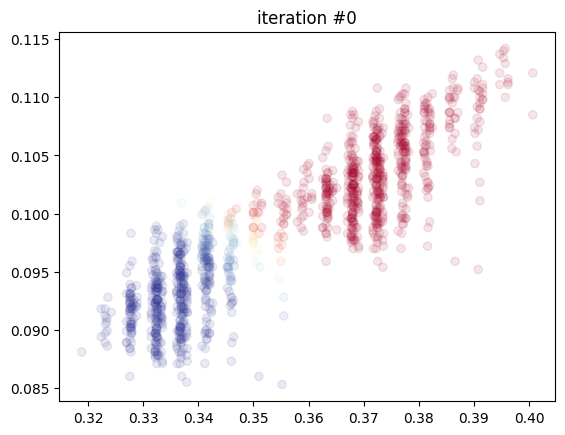

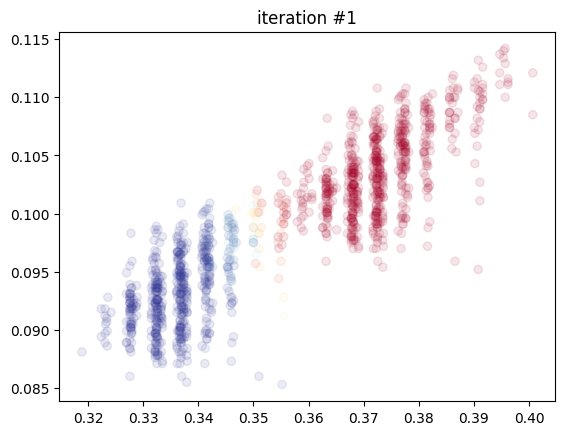

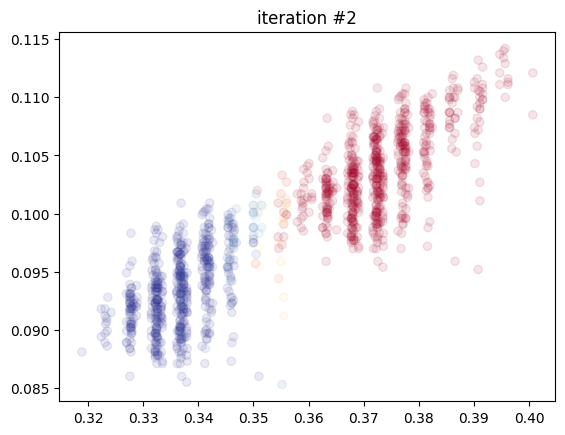

In [119]:
phi,mu,sigma =K_means_initial_model(k,d,data)

print(sigma)
phi, mu, sigma, lol,w = MLE(data[:,::20],(phi,mu[:,::20],sigma[:,::20,::20]),iter=3)


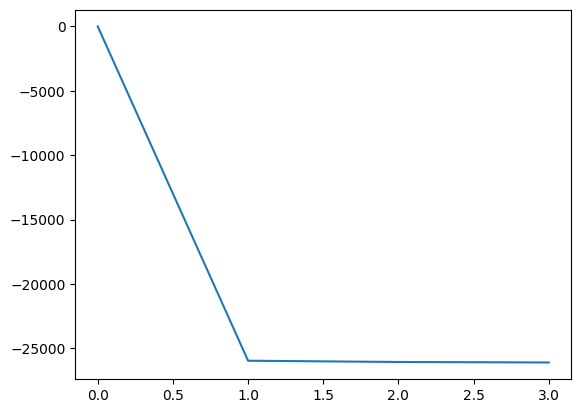

In [120]:
plt.plot(lol)


In [122]:
#print(w)
print(np.sum(w,axis=1))

scores_nt = w[1,:625]
scores_wt = w[1,625:]

[581.86778295 668.13221705]


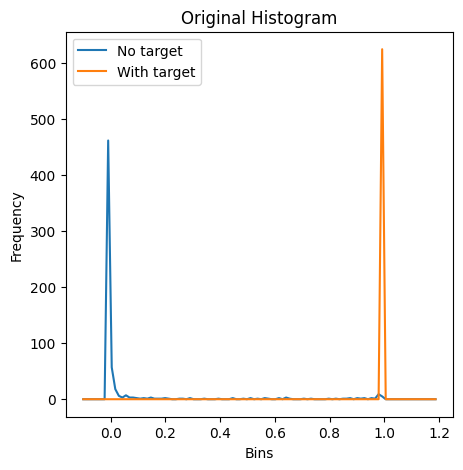

In [123]:
plot_histograms(scores_wt,scores_nt, start = -0.1, end = 1.2, bins = 101)


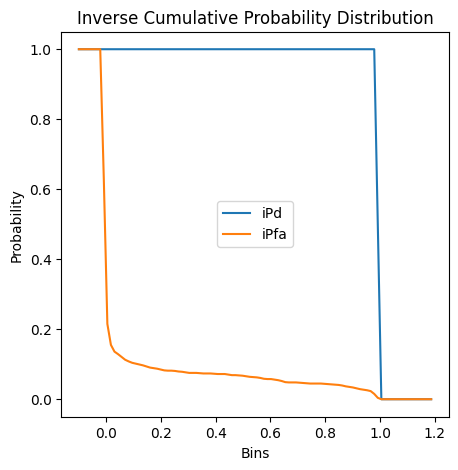

In [125]:
ipd, ipfa = plot_ipd(scores_wt,scores_nt,start=-0.1,end=1.2,X=25,Y=25)


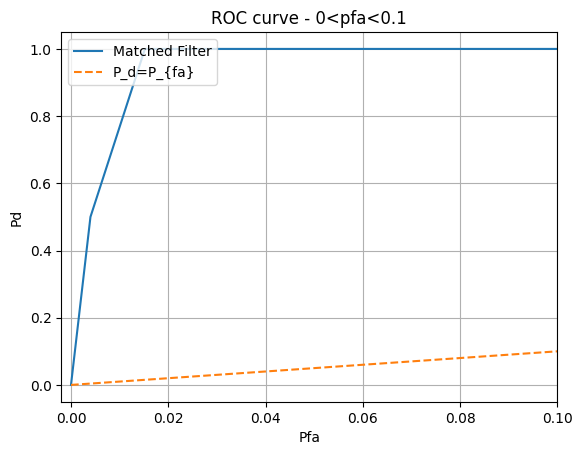

In [126]:
plot_ROC(ipd, ipfa)
